# Import Library

In [8]:
#Import Library
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.layers import Input, Dense, Layer
from keras.models import Model
from keras import backend as K
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import shutil

In [9]:
# read train data and test data from directory
# dir_dataset = "E:\ilmu\Kuliah\sem 7 dan 8\Tugas Akhir\dataset\CICIDS2017\Dataset CICIDS2017"
dir_dataset = 'TRAIN DATA AND TEST DATA DIRECTORY'

df_train = pd.read_csv(dir_dataset + '\\train.csv')
df_test = pd.read_csv(dir_dataset + '\\test.csv')

In [10]:
#  load dataset into train data, train labels, test data and test labels
def load_train_test(df_train, df_test):
    train_x, train_y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

In [11]:
# call function load_train_test()
train_x, train_y, test_x, test_y = load_train_test(df_train, df_test)

In [12]:
# scaling train data and test data
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# Create Model

In [13]:
# Custom layer Densetranspose for NDAE
# NDAE doesn't have decoder 
# NDAE using current layer encoder as decoder 
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'dense': self.dense,
          'activation': self.activation
      })
      return config
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
    self.W = tf.transpose(self.dense.weights[0]) 
    super().build(batch_input_shape)
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.dense.input_shape[-1])
  def call(self, inputs):
    z = tf.matmul(inputs, self.W)
    return self.activation(z + self.biases)

In [14]:
# Custom layer sampling for model VAE
# sampling new data from distribution gaussian
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
# Define encoder and decoder for 1st Auto-Encoder Model (VAE)
latent_dim = 8
num_hidden = (train_x.shape[1], 256, 32)

#Encoder
encoder_inputs = Input(shape=(num_hidden[0],))
encoded_11 = Dense(num_hidden[1], activation='sigmoid')(encoder_inputs)
encoded_13 = Dense(num_hidden[2], activation='sigmoid')(encoded_11)

#sampling
z_mean = Dense(latent_dim, name ="z_mean")(encoded_13)
z_log_var = Dense(latent_dim, name ="z_log_var")(encoded_13)
z = Sampling()([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,))
decoded_11 = Dense(num_hidden[2], activation='sigmoid')(latent_inputs)
decoded_12 = Dense(num_hidden[1], activation='sigmoid')(decoded_11)
decoder_outputs = Dense(num_hidden[0])(decoded_12)

Encoder_1 = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
Decoder_1 = Model(latent_inputs, decoder_outputs, name ="decoder")

In [17]:
# Define VAE model with encoder and decoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
 
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [18]:
# construct VAE model
AE_1 = VAE(Encoder_1, Decoder_1)
AE_1.compile(optimizer ='adam')

In [19]:
# Define 2nd Auto-Encoder Model (NDAE)
num_hidden = (train_x.shape[1], 14, 28, 28)

Dense_21 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_23 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_2 = Input(shape=(num_hidden[0],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)
encoded_23 = Dense_23(encoded_22)

#Decoder
decoded_21 = DenseTranspose(Dense_23, activation='sigmoid')(encoded_23)
decoded_22 = DenseTranspose(Dense_22, activation='sigmoid')(decoded_21)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_22)

AE_2=Model(inputs_2, outputs_2, name='AE_2')
Encoder_2=Model(inputs_2, decoded_22, name='Encoder_2')

In [20]:
# compile 2nd autoencoder 
AE_2.compile(optimizer='adam', loss= 'mse')

In [21]:
# construct random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [24]:
# compile and train the model
AE_1.fit(train_x, train_x, epochs = 10, batch_size = 32)

Epoch 1/10
21209/21209 [==============================] - 61s 3ms/step - loss: 0.6750 - reconstruction_loss: 0.5563 - kl_loss: 0.1187
Epoch 2/10
21209/21209 [==============================] - 60s 3ms/step - loss: 0.6631 - reconstruction_loss: 0.5387 - kl_loss: 0.1244
Epoch 3/10
21209/21209 [==============================] - 57s 3ms/step - loss: 0.6549 - reconstruction_loss: 0.5232 - kl_loss: 0.1317
Epoch 4/10
21209/21209 [==============================] - 58s 3ms/step - loss: 0.6525 - reconstruction_loss: 0.5198 - kl_loss: 0.1327
Epoch 5/10
21209/21209 [==============================] - 60s 3ms/step - loss: 0.6596 - reconstruction_loss: 0.5291 - kl_loss: 0.1305
Epoch 6/10
21209/21209 [==============================] - 65s 3ms/step - loss: 0.6581 - reconstruction_loss: 0.5276 - kl_loss: 0.1304
Epoch 7/10
21209/21209 [==============================] - 60s 3ms/step - loss: 0.6477 - reconstruction_loss: 0.5147 - kl_loss: 0.1330
Epoch 8/10
21209/21209 [==============================] - 58s 

In [25]:
# encode input data
AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(train_x)[2])
AE_1_encoded_test = Decoder_1.predict(Encoder_1.predict(test_x)[2])

5303/5303 [==============================] - 8s 1ms/step


In [26]:
# compile and train the model
AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs = 10, batch_size = 32)

Epoch 1/10
21209/21209 [==============================] - 45s 2ms/step - loss: 0.4187
Epoch 2/10
21209/21209 [==============================] - 43s 2ms/step - loss: 0.4051
Epoch 3/10
21209/21209 [==============================] - 42s 2ms/step - loss: 0.4050
Epoch 4/10
21209/21209 [==============================] - 43s 2ms/step - loss: 0.4050
Epoch 5/10
21209/21209 [==============================] - 42s 2ms/step - loss: 0.4050
Epoch 6/10
21209/21209 [==============================] - 47s 2ms/step - loss: 0.4050
Epoch 7/10
21209/21209 [==============================] - 44s 2ms/step - loss: 0.4050
Epoch 8/10
21209/21209 [==============================] - 43s 2ms/step - loss: 0.4050
Epoch 9/10
21209/21209 [==============================] - 44s 2ms/step - loss: 0.4050
Epoch 10/10
21209/21209 [==============================] - 43s 2ms/step - loss: 0.4050


In [27]:
# encode input data
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

5303/5303 [==============================] - 7s 1ms/step


In [28]:
# training random forest and evaluate accuracy
rfc.fit(AE_2_encoded_train, train_y)
rfc.score(AE_2_encoded_test, test_y)

0.8827495564946278

# Evaluation Metric
Evaluation metrics are used to assess the performance of a model. The metrics used include precision, recall, F1 score, accuracy, and ROC curve.

In [345]:
testResult = rfc.predict(AE_2_encoded_test)

In [346]:
print(classification_report(test_y, testResult))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    136200
           1       0.91      0.44      0.59     33471

    accuracy                           0.88    169671
   macro avg       0.89      0.71      0.76    169671
weighted avg       0.88      0.88      0.86    169671



In [347]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_y, y_pred=testResult)

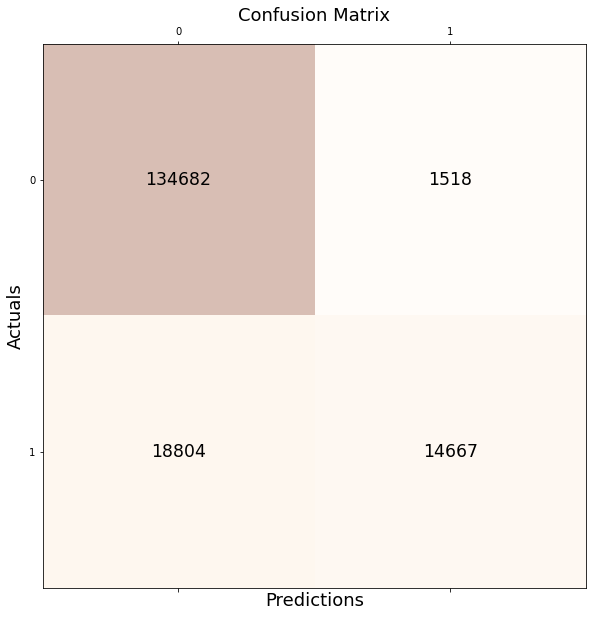

In [348]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

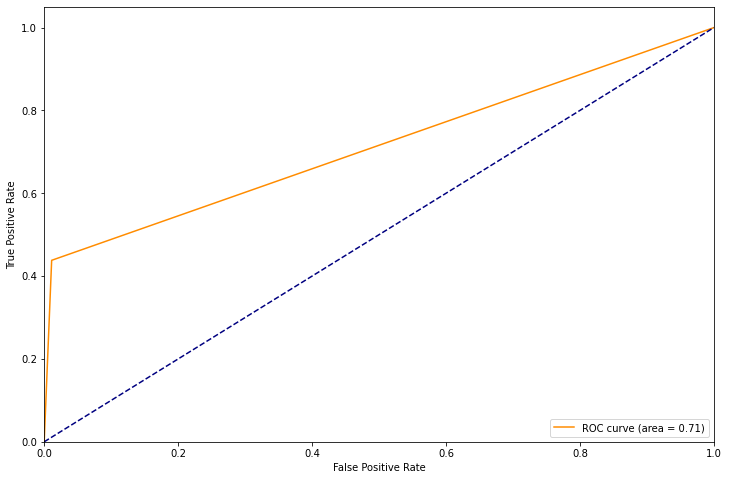

In [349]:
plt.figure(figsize = (12, 8))

fpr, tpr, _ = roc_curve(test_y, testResult)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# 1. Hyperparameter Testing
The hyperparameters varied in this experiment are the batch size and the choice of optimizer. This testing is conducted to find the most optimal hyperparameters based on the highest accuracy. The code used is the same as before

[Adam, RMSprop]

[16, 32, 64, 128, 256]

In [326]:
def hyperparameter_testing(batch_size, opt, results):
    print('==============================')
    print('batch_size =', batch_size)
    print('optimizer =', opt)
    AE_1 = VAE(Encoder_1, Decoder_1)
    AE_1.compile(optimizer = opt)
    AE_1.fit(train_x,train_x,epochs=10,batch_size=batch_size)

    AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(train_x)[2])
    AE_1_encoded_test = Decoder_1.predict(Encoder_1.predict(test_x)[2])

    AE_2.compile(optimizer=opt, loss='mse')
    AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=batch_size)

    AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
    AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)
    rfc.fit(AE_2_encoded_train, train_y)
    acc = rfc.score(AE_2_encoded_test, test_y)
    results.append([acc, opt, batch_size])
    print(rfc.score(AE_2_encoded_test, test_y))
    
    print()

    testResult = rfc.predict(AE_2_encoded_test)
    print(classification_report(test_y, testResult))

In [327]:
optlist = ['rmsprop', 'adam']
batch_size_list = [16, 32, 64, 128, 256]
results = []
for opt in optlist:
    for batch_size in batch_size_list: 
        hyperparameter_testing(batch_size, opt, results)

batch_size = 16
optimizer = rmsprop
Epoch 1/10
42418/42418 [==============================] - 117s 3ms/step - loss: 0.7549 - reconstruction_loss: 0.6744 - kl_loss: 0.0805
Epoch 2/10
42418/42418 [==============================] - 112s 3ms/step - loss: 0.7152 - reconstruction_loss: 0.6139 - kl_loss: 0.1013
Epoch 3/10
42418/42418 [==============================] - 111s 3ms/step - loss: 0.7093 - reconstruction_loss: 0.6078 - kl_loss: 0.1016
Epoch 4/10
42418/42418 [==============================] - 110s 3ms/step - loss: 0.7066 - reconstruction_loss: 0.6047 - kl_loss: 0.1020
Epoch 5/10
42418/42418 [==============================] - 114s 3ms/step - loss: 0.7038 - reconstruction_loss: 0.6010 - kl_loss: 0.1029
Epoch 6/10
42418/42418 [==============================] - 109s 3ms/step - loss: 0.7013 - reconstruction_loss: 0.5974 - kl_loss: 0.1039
Epoch 7/10
42418/42418 [==============================] - 114s 3ms/step - loss: 0.7020 - reconstruction_loss: 0.5964 - kl_loss: 0.1056
Epoch 8/10
42418/42

10605/10605 [==============================] - 35s 3ms/step - loss: 0.3624
Epoch 9/10
10605/10605 [==============================] - 26s 2ms/step - loss: 0.3623
Epoch 10/10
5303/5303 [==============================] - 8s 1ms/step
0.8776101985607441

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    136200
           1       0.92      0.42      0.57     33471

    accuracy                           0.88    169671
   macro avg       0.89      0.70      0.75    169671
weighted avg       0.88      0.88      0.86    169671

batch_size = 128
optimizer = rmsprop
Epoch 1/10
5303/5303 [==============================] - 30s 5ms/step - loss: 0.6459 - reconstruction_loss: 0.5183 - kl_loss: 0.1276
Epoch 2/10
5303/5303 [==============================] - 25s 5ms/step - loss: 0.6440 - reconstruction_loss: 0.5169 - kl_loss: 0.1272
Epoch 3/10
5303/5303 [==============================] - 25s 5ms/step - loss: 0.6434 - reconstruction_loss: 0.5147 - kl_los

5303/5303 [==============================] - 23s 4ms/step - loss: 0.5764 - reconstruction_loss: 0.4335 - kl_loss: 0.1429
Epoch 8/10
5303/5303 [==============================] - 23s 4ms/step - loss: 0.5774 - reconstruction_loss: 0.4337 - kl_loss: 0.1437
Epoch 9/10
5303/5303 [==============================] - 24s 4ms/step - loss: 0.5754 - reconstruction_loss: 0.4310 - kl_loss: 0.1444
Epoch 10/10
5303/5303 [==============================] - 8s 1ms/step
Epoch 1/10
5303/5303 [==============================] - 13s 2ms/step - loss: 0.4845
Epoch 2/10
5303/5303 [==============================] - 12s 2ms/step - loss: 0.4845
Epoch 3/10
5303/5303 [==============================] - 12s 2ms/step - loss: 0.4845
Epoch 4/10
5303/5303 [==============================] - 13s 2ms/step - loss: 0.4844
Epoch 5/10
5303/5303 [==============================] - 12s 2ms/step - loss: 0.4844
Epoch 6/10
5303/5303 [==============================] - 12s 2ms/step - loss: 0.4844
Epoch 7/10
5303/5303 [====================

In [330]:
maxacc = 0
chosen_hyperparameter = None
for result in results:
    acc = result[0]
    if maxacc < acc:
        maxacc = acc
        chosen_hyperparameter = result.copy()

## Result of Hyperparameter Testing

In [352]:
for r in results:
    print(f'accuracy: {r[0]} - optimizer: {r[1]} - batch size: {r[2]}')

accuracy: 0.8590743261959911 - optimizer: rmsprop - batch size: 16
accuracy: 0.8425718007202173 - optimizer: rmsprop - batch size: 32
accuracy: 0.8776101985607441 - optimizer: rmsprop - batch size: 64
accuracy: 0.8530626919155306 - optimizer: rmsprop - batch size: 128
accuracy: 0.8732782856233534 - optimizer: rmsprop - batch size: 256
accuracy: 0.8669483883515745 - optimizer: adam - batch size: 16
accuracy: 0.8027123079371253 - optimizer: adam - batch size: 32
accuracy: 0.882991200617666 - optimizer: adam - batch size: 64
accuracy: 0.8028478643963907 - optimizer: adam - batch size: 128
accuracy: 0.8027417767326178 - optimizer: adam - batch size: 256


# 2. Model Validation Testing
Testing is performed using K-Fold validation with the most optimal hyperparameters. The results of this testing include the precision, recall, accuracy, F1-score, ROC curve, and the training time for each iteration of the model.

In [17]:
def convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list ):
    print('==============================')
    print('optimizer =', opt)
    print('batch size =', batch_size)
    print('KFold = 10')
    kfold = KFold(n_splits=10, shuffle=True)
    total_time1 = 0
    total_time2 = 0
    total_acc = 0
    i = 1
    
    train_x, train_y, _, _ = load_train_test(df_train, df_test)
    for train_idx, valid_idx in kfold.split(train_x):
        AE_1 = VAE(Encoder_1, Decoder_1)
        AE_1.compile(optimizer=opt)
        AE_2.compile(optimizer=opt, loss= 'mse')
        print('\nCurrent KFold = ', i)
        Xtrain, Xvalid = train_x.iloc[train_idx], train_x.iloc[valid_idx]
        Ytrain, Yvalid = train_y.iloc[train_idx], train_y.iloc[valid_idx]
        
        scaler_kfold = StandardScaler()
        scaler_kfold.fit(Xtrain)
        Xtrain_scaled = scaler_kfold.transform(Xtrain)
        Xvalid_scaled = scaler_kfold.transform(Xvalid)
    
        time_before_training_AE_1 = datetime.now()
        AE_1.fit(Xtrain_scaled, Xtrain_scaled, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_1 = datetime.now()
        delta_time_AE_1 = time_after_training_AE_1 - time_before_training_AE_1
        
        AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(Xtrain_scaled)[2])
        AE_1_encoded_valid = Decoder_1.predict(Encoder_1.predict(Xvalid_scaled)[2])

        time_before_training_AE_2 = datetime.now()
        AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_2 = datetime.now()
        delta_time_AE_2 = time_after_training_AE_2 - time_before_training_AE_2
        
        AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
        AE_2_encoded_valid = Encoder_2.predict(AE_1_encoded_valid)

        rfc.fit(AE_2_encoded_train, Ytrain)
            
        print(time_before_training_AE_1)
        print(time_after_training_AE_1)
        print('time taken for training 1st autoencoder', delta_time_AE_1.total_seconds())
        print()
        print(time_before_training_AE_2)
        print(time_after_training_AE_2)
        print('time taken for training 2nd autoencoder', delta_time_AE_2.total_seconds())
        print()
        print('total time =', delta_time_AE_1.total_seconds() + delta_time_AE_2.total_seconds())

        total_time1 += delta_time_AE_1.total_seconds()
        total_time2 += delta_time_AE_2.total_seconds()
        time_list.append([delta_time_AE_1.total_seconds(), delta_time_AE_2.total_seconds()])
        
        print('Data Train')
        trainResult = rfc.predict(AE_2_encoded_train)
        print(rfc.score(AE_2_encoded_train, Ytrain))
        print(classification_report(Ytrain, trainResult))
        
        print('Data Valid')
        validResult = rfc.predict(AE_2_encoded_valid)
        valid_acc = rfc.score(AE_2_encoded_valid, Yvalid)
        total_acc += valid_acc
        acc_list.append(valid_acc)
        print(valid_acc)
        print(classification_report(Yvalid, validResult))
        
        print()
              
        fpr, tpr, _ = roc_curve(Yvalid, validResult)
        roc_auc = auc(fpr, tpr)
        roc_list.append([fpr, tpr, roc_auc])
        print()
        i+=1
        
    avg_time_AE_1 = total_time1 / 10 
    avg_time_AE_2 = total_time2 / 10
    avg_total_val_acc = total_acc / 10
    print('Average training time for AE_1:', avg_time_AE_1, 'seconds')
    print('Average training time for AE_2:', avg_time_AE_2, 'seconds')
    print('Average accuracy of 10 folds :', avg_total_val_acc)

In [18]:
epochs = 10
opt = chosen_hyperparameter[1]
batch_size = chosen_hyperparameter[2]
roc_list = []
time_list = []
acc_list = []
convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list)

optimizer = adam
batch size = 64
KFold = 10

Current KFold =  1
Epoch 1/10
9544/9544 [==============================] - 32s 3ms/step - loss: 0.7801 - reconstruction_loss: 0.7132 - kl_loss: 0.0670
Epoch 2/10
9544/9544 [==============================] - 32s 3ms/step - loss: 0.7193 - reconstruction_loss: 0.6267 - kl_loss: 0.0926
Epoch 3/10
9544/9544 [==============================] - 42s 4ms/step - loss: 0.6925 - reconstruction_loss: 0.5840 - kl_loss: 0.1085
Epoch 4/10
9544/9544 [==============================] - 36s 4ms/step - loss: 0.6746 - reconstruction_loss: 0.5570 - kl_loss: 0.1177
Epoch 5/10
9544/9544 [==============================] - 27s 3ms/step - loss: 0.6678 - reconstruction_loss: 0.5522 - kl_loss: 0.1156
Epoch 6/10
9544/9544 [==============================] - 27s 3ms/step - loss: 0.6591 - reconstruction_loss: 0.5414 - kl_loss: 0.1177
Epoch 7/10
9544/9544 [==============================] - 27s 3ms/step - loss: 0.6613 - reconstruction_loss: 0.5409 - kl_loss: 0.1204
Epoch 8/10
9

9544/9544 [==============================] - 22s 2ms/step - loss: 0.3673
Epoch 10/10
2121/2121 [==============================] - 4s 2ms/step
2023-07-01 20:03:42.758472
2023-07-01 20:09:49.113322
time taken for training 1st autoencoder 366.35485

2023-07-01 20:11:45.379224
2023-07-01 20:15:25.230142
time taken for training 2nd autoencoder 219.850918

total time = 586.205768
Data Train
0.8953542246153896
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    490391
           1       0.97      0.48      0.65    120422

    accuracy                           0.90    610813
   macro avg       0.93      0.74      0.79    610813
weighted avg       0.90      0.90      0.88    610813

Data Valid
0.8758767018329698
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     54493
           1       0.88      0.43      0.58     13375

    accuracy                           0.88     67868
   macro avg      

Epoch 1/10
9544/9544 [==============================] - 37s 4ms/step - loss: 0.5714 - reconstruction_loss: 0.4307 - kl_loss: 0.1407
Epoch 2/10
9544/9544 [==============================] - 36s 4ms/step - loss: 0.5695 - reconstruction_loss: 0.4287 - kl_loss: 0.1408
Epoch 3/10
9544/9544 [==============================] - 29s 3ms/step - loss: 0.5677 - reconstruction_loss: 0.4280 - kl_loss: 0.1398
Epoch 4/10
9544/9544 [==============================] - 30s 3ms/step - loss: 0.5671 - reconstruction_loss: 0.4288 - kl_loss: 0.1384
Epoch 5/10
9544/9544 [==============================] - 31s 3ms/step - loss: 0.5676 - reconstruction_loss: 0.4265 - kl_loss: 0.1411
Epoch 6/10
9544/9544 [==============================] - 29s 3ms/step - loss: 0.5691 - reconstruction_loss: 0.4326 - kl_loss: 0.1365
Epoch 7/10
9544/9544 [==============================] - 28s 3ms/step - loss: 0.5660 - reconstruction_loss: 0.4279 - kl_loss: 0.1381
Epoch 8/10
9544/9544 [==============================] - 29s 3ms/step - loss:

## Result of Validation Model

In [20]:
for i,acc in enumerate(acc_list):
    print(f'fold {i+1} - accuracy: {acc} - time AE1: {time_list[i][0]} - time AE2: {time_list[i][1]}')

fold 1 - accuracy: 0.8709720196260443 - time AE1: 311.627916 - time AE2: 191.743726
fold 2 - accuracy: 0.8836417752107031 - time AE1: 295.235814 - time AE2: 188.925706
fold 3 - accuracy: 0.8620410208050923 - time AE1: 358.452453 - time AE2: 210.526583
fold 4 - accuracy: 0.8720752048093358 - time AE1: 333.474351 - time AE2: 208.674692
fold 5 - accuracy: 0.8758767018329698 - time AE1: 366.35485 - time AE2: 219.850918
fold 6 - accuracy: 0.8802970472092886 - time AE1: 347.284541 - time AE2: 197.886421
fold 7 - accuracy: 0.8785731125125243 - time AE1: 342.350679 - time AE2: 194.262431
fold 8 - accuracy: 0.8821683267519302 - time AE1: 311.582381 - time AE2: 188.468859
fold 9 - accuracy: 0.8802823127247009 - time AE1: 316.280619 - time AE2: 195.961432
fold 10 - accuracy: 0.8800465609712972 - time AE1: 311.552025 - time AE2: 183.354776


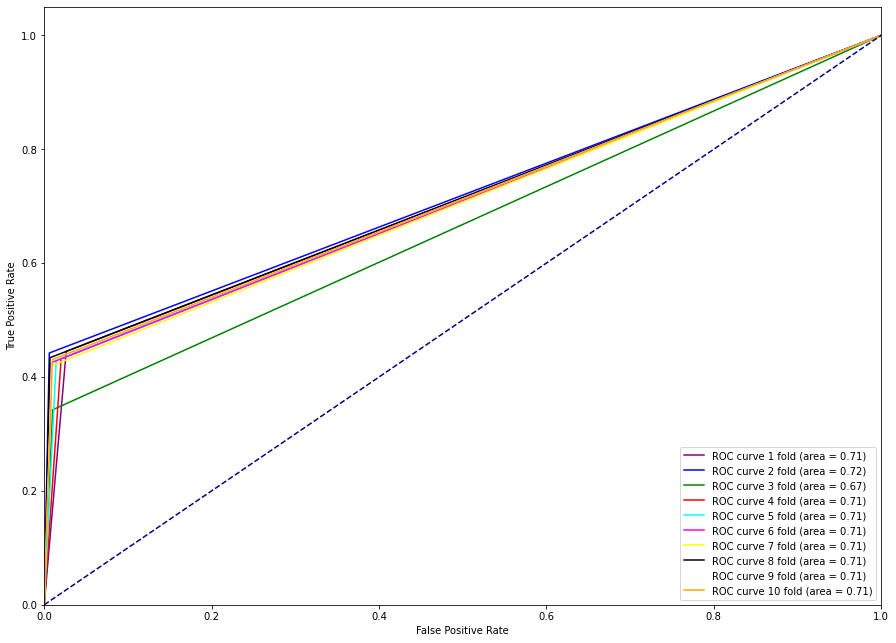

In [21]:
plt.figure(figsize = (15, 11))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple']

for i in range(10):        
    plt.plot(roc_list[i][0], roc_list[i][1], color=colors[i-1], label=f'ROC curve {i+1} fold (area = %0.2f)' % roc_list[i][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [22]:
for i,el in enumerate(roc_list):
    print('ROC Curve', i+1,'fold',el[2])

ROC Curve 1 fold 0.7093222918601385
ROC Curve 2 fold 0.7180318057008042
ROC Curve 3 fold 0.6661470907216082
ROC Curve 4 fold 0.7059348603037071
ROC Curve 5 fold 0.7071425234931143
ROC Curve 6 fold 0.7083781809398885
ROC Curve 7 fold 0.7055268192722398
ROC Curve 8 fold 0.7135094772737638
ROC Curve 9 fold 0.710414452698214
ROC Curve 10 fold 0.710366077297451
